In [1]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, callbacks
import joblib
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

ROOT = Path.cwd().parent
TRAIN_DIR = ROOT / "data" / "heatmaps" / "train"
TEST_DIR  = ROOT / "data" / "heatmaps" / "test"
MODEL_DIR = ROOT / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)
print("Train dir:", TRAIN_DIR)
print("Test dir:", TEST_DIR)


Train dir: /Users/ojasbodke/Desktop/Air G Project/data/heatmaps/train
Test dir: /Users/ojasbodke/Desktop/Air G Project/data/heatmaps/test


In [2]:
img_size = (224,224)
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=12,
    width_shift_range=0.06,
    height_shift_range=0.06,
    zoom_range=0.08,
    horizontal_flip=True,
    brightness_range=(0.8,1.2)
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    str(TRAIN_DIR), target_size=img_size, batch_size=batch_size,
    class_mode='binary', shuffle=True
)

test_gen = test_datagen.flow_from_directory(
    str(TEST_DIR), target_size=img_size, batch_size=batch_size,
    class_mode='binary', shuffle=False
)


Found 400 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [3]:
from tensorflow.keras.applications import MobileNetV2

base = MobileNetV2(weights=None, include_top=False, input_shape=(224,224,3), alpha=1.0)
x = base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.35)(x)
out = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=base.input, outputs=out)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


2025-11-22 14:06:23.119862: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-11-22 14:06:23.119898: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-22 14:06:23.119906: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-11-22 14:06:23.119930: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-22 14:06:23.119989: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 2,387,969 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [4]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
ckpt = callbacks.ModelCheckpoint(str(MODEL_DIR/'cnn_model.h5'), monitor='val_loss', save_best_only=True)

history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=12,
    callbacks=[es, ckpt]
)


Epoch 1/12


2025-11-22 14:06:45.026749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.5002 - loss: 0.9915

25/25 ━━━━━━━━━━━━━━━━━━━━ 39s 538ms/step - accuracy: 0.5100 - loss: 1.0525 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 339ms/step - accuracy: 0.5150 - loss: 1.2554 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 326ms/step - accuracy: 0.4750 - loss: 1.1781 - val_accuracy: 0.5000 - val_loss: 0.6936
Epoch 4/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 327ms/step - accuracy: 0.5050 - loss: 1.2514 - val_accuracy: 0.5000 - val_loss: 0.6936
Epoch 5/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.4935 - loss: 1.1949

25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 340ms/step - accuracy: 0.5150 - loss: 1.1014 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 327ms/step - accuracy: 0.5150 - loss: 0.9435 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 331ms/step - accuracy: 0.4975 - loss: 0.9986 - val_accuracy: 0.5000 - val_loss: 0.6945
Epoch 8/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 331ms/step - accuracy: 0.5150 - loss: 0.9776 - val_accuracy: 0.5000 - val_loss: 0.6940
Epoch 9/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 331ms/step - accuracy: 0.5075 - loss: 0.9536 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 10/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 332ms/step - accuracy: 0.5125 - loss: 0.8384 - val_accuracy: 0.5000 - val_loss: 0.6951


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 283ms/step
              precision    recall  f1-score   support

       metal       0.00      0.00      0.00        60
   non_metal       0.50      1.00      0.67        60

    accuracy                           0.50       120
   macro avg       0.25      0.50      0.33       120
weighted avg       0.25      0.50      0.33       120



/Users/ojasbodke/Desktop/Air G Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/ojasbodke/Desktop/Air G Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/ojasbodke/Desktop/Air G Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

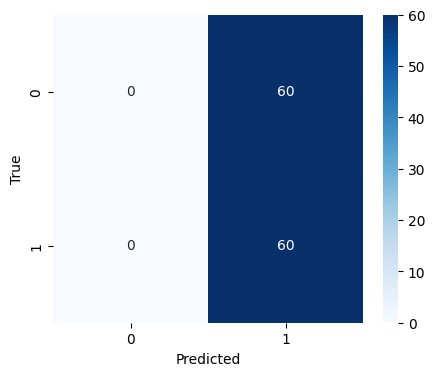

In [5]:
model.load_weights(str(MODEL_DIR/'cnn_model.h5'))
test_gen.reset()
preds = model.predict(test_gen, verbose=1)
y_pred = (preds.ravel() > 0.5).astype(int)
y_true = test_gen.classes

print(classification_report(y_true, y_pred, target_names=list(train_gen.class_indices.keys())))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()


In [6]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_flat(directory):
    X, y = [], []
    classes = sorted([p.name for p in Path(directory).iterdir() if p.is_dir()])
    for idx, cls in enumerate(classes):
        for f in (Path(directory)/cls).glob("*.png"):
            img = load_img(f, target_size=img_size)
            arr = img_to_array(img) / 255.0
            X.append(arr.flatten())
            y.append(idx)
    return np.array(X), np.array(y)

X_train, y_train = load_flat(TRAIN_DIR)
X_test, y_test   = load_flat(TEST_DIR)

svm = SVC(kernel='rbf', C=1.0, probability=True)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("SVM baseline:\n", classification_report(y_test, y_pred_svm, target_names=['metal','non_metal']))
joblib.dump(svm, MODEL_DIR/'svm_baseline.joblib')


SVM baseline:
               precision    recall  f1-score   support

       metal       0.46      0.38      0.42        60
   non_metal       0.47      0.55      0.51        60

    accuracy                           0.47       120
   macro avg       0.47      0.47      0.46       120
weighted avg       0.47      0.47      0.46       120



['/Users/ojasbodke/Desktop/Air G Project/models/svm_baseline.joblib']